## Network implementation

In [4]:
from datetime import datetime
from random import randint
import gzip, pickle
import numpy as np
import random
import matplotlib.pyplot as plt
import time

f = gzip.open('mnist.pkl.gz')
data = pickle.load(f, encoding='latin1')

# training set with onehot encoding for labels
train_data = data[0][0]
train_labels = np.zeros((train_data.shape[0], 10))
train_labels[np.arange(train_labels.shape[0]), data[0][1]] = 1

# validation and test sets, normal encoding for labels
valid_data, valid_labels = data[1]
test_data, test_labels = data[2]

## Network implementation

In [5]:
class NN(object):
    
    def __init__(self, hidden_dims=(1024,2048), n_hidden=2, mode='train', datapath=None, model_path=None,
                batchsize=64, lr=0.0001, delta=.5, activation="ReLU", initialization="normal", epsilon=1e-8):
        
        self.dims = (784,) + hidden_dims + (10,)
        self.n_hidden = n_hidden
        self.mode = mode
        self.datapath = datapath
        self.model_path = model_path
        self.batchsize = batchsize
        self.lr = lr
        self.delta = delta
        self.epsilon = epsilon
        
        # set activation function for hidden layers
        if activation == "ReLU":
            self.activation = self.ReLU
            self.activation_prime = self.ReLU_prime
        elif activation == "sigmoid":
            self.activation = self.sigmoid
            self.activation_prime = self.sigmoid_prime
        elif activation == "tanh":
            self.activation = self.tanh
            self.activation_prime = self.tanh_prime
        else:
            raise ValueError('Invalid activation function specified: ' + str(activation))
        
        # network parameters
        self.W = []
        self.b = [np.zeros(self.dims[i]) for i in range(1, len(self.dims))]
        
        # weight initialization
        self.initialize_weights(n_hidden, self.dims, initialization)
        
        # keep count of the loss of each epoch
        self.losses = []
        
        # keep count of current training epochs
        self.epoch_cnt = 1
    
    ################################################
    #  Weights initialization and parameter count  #
    ################################################
    
    def initialize_weights(self, n_hidden, dims, option):
        
        if option == "zero":
            for i in range(n_hidden + 1):
                self.W.append( np.zeros((dims[i+1], dims[i])) )
        
        elif (option == "normal"):
            for i in range(n_hidden + 1):
                self.W.append( np.random.normal(0, 1, (dims[i+1], dims[i])) )
        
        elif (option == "glorot"):
            for i in range(n_hidden + 1):
                di = np.sqrt(6/(dims[i]+dims[i+1]))
                self.W.append( np.random.uniform(-di, di, (dims[i+1], dims[i])) )
        
        else:
            raise ValueError('Invalid weight initialization specified: ' + str(option))
        
    def display_network(self, title=None):
        
        if title: print(title)
        
        for i in range(self.n_hidden + 1):
            print("Layer", i+1, end=" - ")
            print("W:" + str(self.W[i].shape), end="\t")
            print("b:" + str(self.b[i].shape))
        
        weights_cnt = sum(map(np.size, self.W))
        bias_cnt = sum(map(np.size, self.b))
        print("Total number of parameters:", weights_cnt + bias_cnt, "\n")
    
    #################################################
    #  Activation functions  and their derivatives  #
    #################################################
    
    def ReLU(self, input):
        return np.maximum(0, input)
    
    def ReLU_prime(self, input):
        return np.where(input > 0, 1, 0)
    
    def sigmoid(self, input):
        return 1 / (1 + np.exp(-input))
    
    def sigmoid_prime(self, input):
        return self.sigmoid(input) * (1 - self.sigmoid(input))
    
    def tanh(self, input):
        return 2 / (1 + np.exp(-2*input)) - 1
    
    def tanh_prime(self, input):
        return 1 - self.tanh(input)**2
    
    def softmax(self, input):
        rescaled = input - np.amax(input, axis=1)[:,np.newaxis] # for numerical stability
        input_exp = np.exp(rescaled)
        return input_exp / np.sum(input_exp, axis=1)[:,np.newaxis]
    
    ########################################
    #  Forward, backward, loss and update  #
    ########################################
    
    def forward(self, input):
        
        # cache stores z = Wx + b of every layer for backprop (z=x for first layer)
        cache = [input]
        
        out = input
        for i in range(self.n_hidden):
            out = out @ self.W[i].T + self.b[i] # compute z = Wx + b
            cache.append(out) # store z for backprop
            out = self.activation(out) # compute a = activation(z)
        
        out = out @ self.W[-1].T + self.b[-1]
        cache.append(out)
        out = self.softmax(out)
        
        return out, cache
    
    def loss(self, predictions, labels):
        if labels.ndim == 2:
            # onehot label encoding
            return -np.sum(labels * np.log(predictions + self.epsilon))
        else:
            # normal label encoding
            return -np.mean(np.log(predictions + self.epsilon)[np.arange(labels.shape[0]), labels])
    
    def backward(self, cache, labels):
        
        # cache contains z = Wx + b of every layer (z=x for first layer)
        
        grads_a = [0] * (self.n_hidden + 1)
        
        grads_a[-1] = self.softmax(cache[-1]) - labels
        for i in range(self.n_hidden-1, -1, -1):
            grads_a[i] = grads_a[i+1] @ self.W[i+1] * self.activation_prime(cache[i+1])
        
        grads_W = [0] * (self.n_hidden + 1)
        grads_b = [0] * (self.n_hidden + 1)
        
        for i in range(self.n_hidden, -1, -1):
            grads_W[i] = grads_a[i].T @ self.activation(cache[i]) / labels.shape[0]
            grads_b[i] = np.mean(grads_a[i], axis=0)
            
        return (grads_W, grads_b)
    
    def update(self, grads, lr):
        for i in range(self.n_hidden + 1):
            self.W[i] -= lr * grads[0][i]
            self.b[i] -= lr * grads[1][i]
        
    ##############################
    #  Train and test functions  #
    ##############################
    
    def train(self, train_data, train_labels, n_epochs, verbose=True):
        
        for epoch in range(n_epochs):
            
            if verbose:
                print(datetime.now(), "-", "Epoch", self.epoch_cnt, end=": ") 
            
            # learning rate for this epoch
            t = max(1, self.epoch_cnt)
            lr = self.lr / t**self.delta
            
            epoch_loss = 0
            start, end = 0, self.batchsize
            
            while start < train_data.shape[0]:
                
                # forward pass and mini-batch loss
                predictions, cache = self.forward(train_data[start:end])
                epoch_loss += self.loss(predictions, train_labels[start:end])
                
                # backward pass and update
                grads = self.backward(cache, train_labels[start:end])
                self.update(grads, lr)
                
                # start/end for next mini-batch
                start = end
                end += self.batchsize
            
            mean_epoch_loss = epoch_loss / train_data.shape[0]
            if verbose:
                print("loss =", mean_epoch_loss)
            
            self.losses.append(mean_epoch_loss)
            self.epoch_cnt += 1
            
            return mean_epoch_loss
        
    def test(self, test_data, test_labels, verbose=True):
        
        predictions, cache = self.forward(test_data)
        successes = (np.argmax(predictions, axis=1) == test_labels)
        
        success_rate = 100 * np.sum(successes) / test_data.shape[0]
        
        if verbose:
            print(str(success_rate) + "% success")
        
        return self.loss(predictions, test_labels)
    
    ############################################
    #  Finite difference computation function  #
    ############################################
    
    def finite_diff(self, sample, label):
        random.seed(9001)
        #first layer weight
        weight_save = np.copy(self.W[1])
        
        #choose five random value from set N
        num_N = 5
        P = np.min([10, self.dims[2]])
        w_size = self.dims[1]
        N = []
        K = [1, 5]
        fi_grad = np.zeros((num_N, P, w_size))
        for num_N in range(num_N):
            i = random.randint(0,5)
            k = K[random.randint(0,1)]
            N.append(k * (10**i))
        
        N.sort()
        print(N)
        #calculate finite difference for first 10 weights in first layer
        for i in range(len(N)):
            epsilon = 1 / N[i]
            print("Set Epsilon = ", epsilon)
            grad = np.zeros((P,w_size))
            for p in range(P):
                print("Calculate ", p, "hidden unit!!") 
                #restore the original weight before going to next finite difference calculation
                self.W[1] = np.copy(weight_save)
                for z in range(w_size):
                    w1 = np.copy(self.W[1])
                    w2 = np.copy(self.W[1])

                    w1[p][z] -= epsilon
                    w2[p][z] += epsilon

                    #theta(i) - epsilon
                    self.W[1] = np.copy(w1)
                    L1, dum = self.forward(sample)
                    L1_loss = self.loss(L1, label)
                    #theta(i) + epsilon
                    self.W[1] = np.copy(w2)
                    L2, dum = self.forward(sample)
                    L2_loss = self.loss(L2, label)
                    g = (L2_loss-L1_loss)/(2*epsilon)
                    grad[p,z] = g
                    
                    
            fi_grad[i,:] = grad
            
        self.W[1] = np.copy(weight_save)
        #True gradient Calculation
        prediction, cache = self.forward(sample)
        loss = self.loss(prediction, label)
        grads = self.backward(cache, label)
        
        #fi_grad(finite_difference)
        
        return N, fi_grad, grads[0][1][0:10,:]

# Average loss per training example

## Network parameters

In [6]:
hidden_dims = (512, 1024)
n_hidden = 2
mode = 'train'
datapath = None
model_path = None
batchsize = 64
lr = .001
delta = .5
activation = "ReLU"

## Average loss over initialization methods

GLOROT INITIALIZATION:
Layer 1 - W:(512, 784)	b:(512,)
Layer 2 - W:(1024, 512)	b:(1024,)
Layer 3 - W:(10, 1024)	b:(10,)
Total number of parameters: 937482 

2019-02-17 14:00:11.384010 - Epoch 1: loss = 2.0688190355192146
2019-02-17 14:00:31.838006 - Epoch 2: loss = 1.631295016894271
2019-02-17 14:00:50.333243 - Epoch 3: loss = 1.3180200304630643
2019-02-17 14:01:08.770841 - Epoch 4: loss = 1.1058932510031625
2019-02-17 14:01:25.939249 - Epoch 5: loss = 0.9641664759480044
2019-02-17 14:01:43.702688 - Epoch 6: loss = 0.8660849745780653
2019-02-17 14:02:02.941290 - Epoch 7: loss = 0.7949881578542642
2019-02-17 14:02:25.526809 - Epoch 8: loss = 0.7412075592855083
2019-02-17 14:02:45.591606 - Epoch 9: loss = 0.6990583295941705
2019-02-17 14:03:06.737495 - Epoch 10: loss = 0.6650674928317611


NORMAL INITIALIZATION:
Layer 1 - W:(512, 784)	b:(512,)
Layer 2 - W:(1024, 512)	b:(1024,)
Layer 3 - W:(10, 1024)	b:(10,)
Total number of parameters: 937482 

2019-02-17 14:03:35.878002 - Epoch 1: loss =

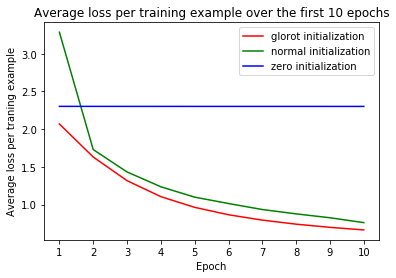

In [27]:
initializations = ["glorot", "normal", "zero"]
colors = ["r", "g", "b"]

n_epochs = 10
xrange = np.arange(n_epochs) + 1

for init, c in zip(initializations, colors):
    
    np.random.seed(6135)
    
    neural_net = NN(hidden_dims, n_hidden, mode, datapath, model_path,
                    batchsize, lr, delta, activation, initialization=init)
    neural_net.display_network(init.upper() + " INITIALIZATION:")
    
    neural_net.train(train_data, train_labels, n_epochs)
    print("\n")
        
    plt.plot(xrange, neural_net.losses, color=c, label=(init + " initialization"))

plt.title("Average loss per training example over the first 10 epochs")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average loss per traning example")
plt.xticks(xrange)
plt.show()

# Hyperparameter search using glorot initialization

In [42]:
# fixed settings for building our networks
n_hidden = 2
mode = 'train'
datapath = None
model_path = None
initialization = "glorot"

# don't display loss nor valid success rate at the end of each epoch
verbose = False

# early stopping hyperparameters
max_number_of_epochs = 15
patience = 5

In [20]:
best_success_rate = 0

# testing all combinations of a subset of hyperparameters
for batchsize in [256, 32, 4]:
    for hidden_dims in [(128, 4096), (256, 2048), (512, 1024), (1024, 128)]:
        for activation in ["ReLU", "sigmoid", "tanh"]:
            for lr in [.1, .01, .001]:
                for delta in [.5, .75, .9]:
                    
                    start_time = datetime.now()
                    
                    params = {
                        "batchsize": batchsize,
                        "hidden_dims": hidden_dims,
                        "activation": activation,
                        "lr": lr,
                        "delta": delta,
                    }
                    
                    print(params)
                    
                    # instantiate the network
                    np.random.seed(6135)
                    neural_net = NN(hidden_dims, n_hidden, mode, datapath, model_path,
                                    batchsize, lr, delta, activation, initialization)
                    
                    # reset success rate and patience for the new network
                    current_success_rate = 0
                    patience_timer = 0
                    
                    # train until 'max number of epochs' of no progress during 'patience' number of epochs 
                    while patience_timer < patience and neural_net.epoch_cnt < max_number_of_epochs:
                        neural_net.train(train_data, train_labels, n_epochs=1, verbose=verbose)
                        success_rate = neural_net.test(valid_data, valid_labels, verbose=verbose)
                        if success_rate > current_success_rate:
                            current_success_rate = success_rate
                            patience_timer = 0
                        else:
                            patience_timer += 1
                            
                    # if current network is better on valid set, save as new best network
                    if current_success_rate > best_success_rate:
                        
                        best_success_rate = current_success_rate
                        best_epoch = neural_net.epoch_cnt - patience_timer
                        best_params = params
                        
                        print("Best success rate:", best_success_rate, end="%\n")
                        print("Reached after", best_epoch, "epochs and",
                              datetime.now() - start_time, "time\n")
                        
                    else:
                        print("   Success rate:", current_success_rate, end="%\n")

{'batchsize': 256, 'hidden_dims': (128, 4096), 'activation': 'ReLU', 'lr': 0.1, 'delta': 0.5}
Best success rate: 95.75%
Reached after 15 epochs and 0:02:25.243072 time

{'batchsize': 256, 'hidden_dims': (128, 4096), 'activation': 'ReLU', 'lr': 0.1, 'delta': 0.75}
   Success rate: 94.97%
{'batchsize': 256, 'hidden_dims': (128, 4096), 'activation': 'ReLU', 'lr': 0.1, 'delta': 0.9}
   Success rate: 94.47%
{'batchsize': 256, 'hidden_dims': (128, 4096), 'activation': 'ReLU', 'lr': 0.01, 'delta': 0.5}
   Success rate: 89.84%
{'batchsize': 256, 'hidden_dims': (128, 4096), 'activation': 'ReLU', 'lr': 0.01, 'delta': 0.75}
   Success rate: 88.48%
{'batchsize': 256, 'hidden_dims': (128, 4096), 'activation': 'ReLU', 'lr': 0.01, 'delta': 0.9}
   Success rate: 87.46%
{'batchsize': 256, 'hidden_dims': (128, 4096), 'activation': 'ReLU', 'lr': 0.001, 'delta': 0.5}
   Success rate: 63.91%
{'batchsize': 256, 'hidden_dims': (128, 4096), 'activation': 'ReLU', 'lr': 0.001, 'delta': 0.75}
   Success rate: 58

   Success rate: 44.69%
{'batchsize': 256, 'hidden_dims': (512, 1024), 'activation': 'sigmoid', 'lr': 0.01, 'delta': 0.9}
   Success rate: 36.43%
{'batchsize': 256, 'hidden_dims': (512, 1024), 'activation': 'sigmoid', 'lr': 0.001, 'delta': 0.5}
   Success rate: 12.08%
{'batchsize': 256, 'hidden_dims': (512, 1024), 'activation': 'sigmoid', 'lr': 0.001, 'delta': 0.75}
   Success rate: 12.08%
{'batchsize': 256, 'hidden_dims': (512, 1024), 'activation': 'sigmoid', 'lr': 0.001, 'delta': 0.9}
   Success rate: 12.08%
{'batchsize': 256, 'hidden_dims': (512, 1024), 'activation': 'tanh', 'lr': 0.1, 'delta': 0.5}
   Success rate: 93.89%
{'batchsize': 256, 'hidden_dims': (512, 1024), 'activation': 'tanh', 'lr': 0.1, 'delta': 0.75}
   Success rate: 93.06%
{'batchsize': 256, 'hidden_dims': (512, 1024), 'activation': 'tanh', 'lr': 0.1, 'delta': 0.9}
   Success rate: 92.81%
{'batchsize': 256, 'hidden_dims': (512, 1024), 'activation': 'tanh', 'lr': 0.01, 'delta': 0.5}
   Success rate: 90.47%
{'batchsiz

Best success rate: 98.07%
Reached after 15 epochs and 0:02:49.263820 time

{'batchsize': 32, 'hidden_dims': (256, 2048), 'activation': 'ReLU', 'lr': 0.1, 'delta': 0.75}
   Success rate: 97.98%
{'batchsize': 32, 'hidden_dims': (256, 2048), 'activation': 'ReLU', 'lr': 0.1, 'delta': 0.9}
   Success rate: 97.93%
{'batchsize': 32, 'hidden_dims': (256, 2048), 'activation': 'ReLU', 'lr': 0.01, 'delta': 0.5}
   Success rate: 95.59%
{'batchsize': 32, 'hidden_dims': (256, 2048), 'activation': 'ReLU', 'lr': 0.01, 'delta': 0.75}
   Success rate: 94.73%
{'batchsize': 32, 'hidden_dims': (256, 2048), 'activation': 'ReLU', 'lr': 0.01, 'delta': 0.9}
   Success rate: 94.16%
{'batchsize': 32, 'hidden_dims': (256, 2048), 'activation': 'ReLU', 'lr': 0.001, 'delta': 0.5}
   Success rate: 90.07%
{'batchsize': 32, 'hidden_dims': (256, 2048), 'activation': 'ReLU', 'lr': 0.001, 'delta': 0.75}
   Success rate: 88.59%
{'batchsize': 32, 'hidden_dims': (256, 2048), 'activation': 'ReLU', 'lr': 0.001, 'delta': 0.9}
 

   Success rate: 80.88%
{'batchsize': 32, 'hidden_dims': (1024, 128), 'activation': 'sigmoid', 'lr': 0.001, 'delta': 0.5}
   Success rate: 46.29%
{'batchsize': 32, 'hidden_dims': (1024, 128), 'activation': 'sigmoid', 'lr': 0.001, 'delta': 0.75}
   Success rate: 35.46%
{'batchsize': 32, 'hidden_dims': (1024, 128), 'activation': 'sigmoid', 'lr': 0.001, 'delta': 0.9}
   Success rate: 30.77%
{'batchsize': 32, 'hidden_dims': (1024, 128), 'activation': 'tanh', 'lr': 0.1, 'delta': 0.5}
   Success rate: 97.62%
{'batchsize': 32, 'hidden_dims': (1024, 128), 'activation': 'tanh', 'lr': 0.1, 'delta': 0.75}
   Success rate: 97.49%
{'batchsize': 32, 'hidden_dims': (1024, 128), 'activation': 'tanh', 'lr': 0.1, 'delta': 0.9}
   Success rate: 97.32%
{'batchsize': 32, 'hidden_dims': (1024, 128), 'activation': 'tanh', 'lr': 0.01, 'delta': 0.5}
   Success rate: 94.77%
{'batchsize': 32, 'hidden_dims': (1024, 128), 'activation': 'tanh', 'lr': 0.01, 'delta': 0.75}
   Success rate: 93.92%
{'batchsize': 32, 'h

   Success rate: 98.21%
{'batchsize': 4, 'hidden_dims': (512, 1024), 'activation': 'ReLU', 'lr': 0.1, 'delta': 0.9}
   Success rate: 98.2%
{'batchsize': 4, 'hidden_dims': (512, 1024), 'activation': 'ReLU', 'lr': 0.01, 'delta': 0.5}
   Success rate: 98.04%
{'batchsize': 4, 'hidden_dims': (512, 1024), 'activation': 'ReLU', 'lr': 0.01, 'delta': 0.75}
   Success rate: 98.01%
{'batchsize': 4, 'hidden_dims': (512, 1024), 'activation': 'ReLU', 'lr': 0.01, 'delta': 0.9}
   Success rate: 97.93%
{'batchsize': 4, 'hidden_dims': (512, 1024), 'activation': 'ReLU', 'lr': 0.001, 'delta': 0.5}
   Success rate: 95.55%
{'batchsize': 4, 'hidden_dims': (512, 1024), 'activation': 'ReLU', 'lr': 0.001, 'delta': 0.75}
   Success rate: 94.67%
{'batchsize': 4, 'hidden_dims': (512, 1024), 'activation': 'ReLU', 'lr': 0.001, 'delta': 0.9}
   Success rate: 94.18%
{'batchsize': 4, 'hidden_dims': (512, 1024), 'activation': 'sigmoid', 'lr': 0.1, 'delta': 0.5}
   Success rate: 96.45%
{'batchsize': 4, 'hidden_dims': (51

In [55]:
# best combination of hyperparameters we found
batchsize = 4
hidden_dims = (1024, 128)
activation = "ReLU"
lr = .1
delta = .5

np.random.seed(6135)
n_epochs = 15

neural_net = NN(hidden_dims, n_hidden, mode, datapath, model_path,
                batchsize, lr, delta, activation, initialization)
neural_net.display_network()

# retrain the model to get back the best success rate on validation set
neural_net.train(train_data, train_labels, n_epochs)

Layer 1 - W:(1024, 784)	b:(1024,)
Layer 2 - W:(128, 1024)	b:(128,)
Layer 3 - W:(10, 128)	b:(10,)
Total number of parameters: 936330 

2019-02-17 15:23:15.028374 - Epoch 1: loss = 0.23640008757004696
2019-02-17 15:24:28.177607 - Epoch 2: loss = 0.08659165175077847
2019-02-17 15:25:46.750415 - Epoch 3: loss = 0.04660182225329116
2019-02-17 15:26:58.712847 - Epoch 4: loss = 0.027829906773533898
2019-02-17 15:28:04.780017 - Epoch 5: loss = 0.01439144030915317
2019-02-17 15:29:11.443898 - Epoch 6: loss = 0.010898855491235097
2019-02-17 15:30:17.742532 - Epoch 7: loss = 0.0059072117083672675
2019-02-17 15:31:24.503441 - Epoch 8: loss = 0.002474453170300355
2019-02-17 15:32:31.290374 - Epoch 9: loss = 0.0012276440710232064
2019-02-17 15:33:37.390012 - Epoch 10: loss = 0.0005660651158039936
2019-02-17 15:34:44.110680 - Epoch 11: loss = 0.00035520756811343543
2019-02-17 15:35:50.771313 - Epoch 12: loss = 0.0002871052061949196
2019-02-17 15:36:57.309573 - Epoch 13: loss = 0.00024321316597118291


In [ ]:
# success rates on validation and test sets

print("Validation set:", end='\t')
neural_net.test(valid_data, valid_labels)

print("Test set:", end='\t')
neural_net.test(test_data, test_labels)

print("", end="")

## Training vs validation loss

In [7]:
# hyperparameters for comparison with CNN model
batchsize = 64
hidden_dims = (1024, 128)
activation = "ReLU"
lr = .1
delta = .5

In [8]:
# instanciate the network
np.random.seed(6135)
net_glorot = NN(hidden_dims, n_hidden, mode, datapath, model_path,
                batchsize, lr, delta, activation, initialization="glorot")

train_loss = []
validation_loss = []

start_time = time.time()
for i in range(10):
    t_loss = net_glorot.train(train_data, train_labels, 1)
    v_loss = net_glorot.test(valid_data, valid_labels)
    
    train_loss.append(t_loss)
    validation_loss.append(v_loss)
print("--- %s seconds ---" % (time.time() - start_time))

2019-02-17 20:22:53.481380 - Epoch 1: loss = 0.3176248367426876
94.91% success
2019-02-17 20:23:03.060842 - Epoch 2: loss = 0.13983250549600587
96.65% success
2019-02-17 20:23:12.323668 - Epoch 3: loss = 0.10266378880242755
97.06% success
2019-02-17 20:23:21.177995 - Epoch 4: loss = 0.08214791449521514
97.3% success
2019-02-17 20:23:29.750310 - Epoch 5: loss = 0.0684519073085157
97.5% success
2019-02-17 20:23:38.104780 - Epoch 6: loss = 0.05850506588458464
97.59% success
2019-02-17 20:23:48.477413 - Epoch 7: loss = 0.05089414956866496
97.71% success
2019-02-17 20:23:58.015130 - Epoch 8: loss = 0.04487605988284386
97.76% success
2019-02-17 20:24:09.302355 - Epoch 9: loss = 0.039987837964108576
97.83% success
2019-02-17 20:24:20.127664 - Epoch 10: loss = 0.03591632487810699
97.89% success
--- 94.98296976089478 seconds ---


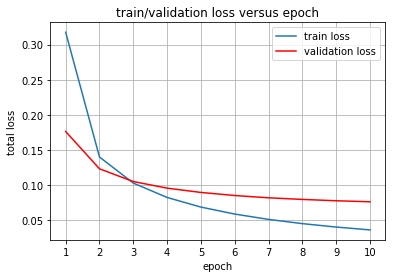

Test Accuracy:
97.69% success


In [9]:
#%%
#plot train/validation loss versus epoch
x = np.arange(10) + 1
plt.title("train/validation loss versus epoch")
plt.xlabel("epoch")
plt.ylabel("total loss")
plt.plot(x, train_loss[:10],label="train loss")
plt.plot(x, validation_loss[:10], color='red', label="validation loss")
plt.legend(loc='upper right')
plt.xticks(x)
plt.grid(True)
plt.show()

print ("Test Accuracy:")
#test set
v_loss = net_glorot.test(test_data, test_labels)

# Finite difference

In [ ]:
#finite difference gradient for first 10 weights in first layer
Ns, f_grad, t_grad = net_glorot.finite_diff(np.expand_dims(train_data[0],axis=0),
                                            np.expand_dims(train_labels[0],axis=0))

print (Ns)

#calculate maximum difference
fgd = []
for i in range(len(Ns)):
    euclidean = np.sum((t_grad-f_grad[i])**2, axis=1)
    fgd.append(np.max(euclidean))

#plot the maximum difference
plt.figure()
plt.plot(Ns, np.log(fgd))
plt.xlabel('N')
plt.ylabel('Log of maximum difference')
plt.grid(True)
plt.show()

[5, 100, 10000, 50000, 500000]
Set Epsilon =  0.2
Calculate  0 hidden unit!!
Calculate  1 hidden unit!!
Calculate  2 hidden unit!!
